## Re-analyze matrix built by the merged clade peaks from LSI-1
##### Features: merged peaks from LSI-1 clades
##### Cells: Aggregated ATAC nuclei

In [1]:
import os
import csv
import scipy
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy.api as epi
%config InlineBackend.figure_format = "retina"
os.chdir("..")

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
RESULTS_FILE = "data/epi/merged_peak_count_matrix_results.h5ad"

METADATA_PATH = "/Users/mukkab/Documents/PhD/snATAC-seq/CZI/Metadata/sample_randomizer_metadata.csv"
GEM_TO_NGI_ID = {"1" : "P20056_1001",
                "2" : "P20056_1002",
                "3" : "P20056_1003",
                "4" : "P20056_1004", 
                "5" : "P20057_1001",
                "6" : "P20057_1002",
                "7" : "P20057_1003"}
NGI_ID_TO_GEM = {v: k for k, v in GEM_TO_NGI_ID.items()}

In [3]:
adata = ad.read("data/epi/merged_cluster_peak_count_matrix.h5ad")
adata

AnnData object with n_obs × n_vars = 19062 × 261304

In [4]:
bcd_list = adata.obs_names.to_list()
NGI_ID_list = [GEM_TO_NGI_ID[bcd.split("-")[-1]] for bcd in bcd_list] 
adata.obs["NGI_ID"] = NGI_ID_list

meta = pd.read_csv(METADATA_PATH, sep=",")
meta = meta[meta["NGI_ID"].notna()]

sample_attributes = meta.columns.to_list()
rem_ = ["NGI_ID", "Box", "10XATAC_batch"]
for i in rem_:
    sample_attributes.remove(i)

#populates anndata.obs
for attribute in sample_attributes:
    adata.obs[attribute] = [meta.loc[meta.NGI_ID == i, attribute].iloc[0] for i in NGI_ID_list]

In [24]:
## get barcodes of doublets identified from ArchR.
ARCHR_ALL_BCD = "data/archr_all_bcd.csv"
ARCHR_SINGLET_BCD = "data/archr_singlet_bcd.csv"

with open(ARCHR_ALL_BCD, newline='') as f:
    reader = csv.reader(f)
    archr_all = list(reader)

with open(ARCHR_SINGLET_BCD, newline='') as f:
    reader = csv.reader(f)
    archr_singlets = list(reader)
    
#change archr_barcode naming style to match anndata.obs
archr_list = [archr_all, archr_singlets]
idx = 0
for ls in archr_list:
    tmp = []
    for archr_bcd in ls[1:]:
        ngi_id,bcd = archr_bcd[-1].split("#")
        tmp.append(bcd[:-1] + NGI_ID_TO_GEM[ngi_id])
    idx += 1
    if idx == 1:
        archr_all = tmp
    else:
        archr_singlets = tmp

# get doublet barcodes
archr_doublets = [bcd for bcd in archr_all if bcd not in archr_singlets]
#add doublet attribute
adata.obs["ArchR_doublet"] = ["True" if bcd in archr_doublets  else "False" for bcd in bcd_list]

In [22]:
# add gene annotations 
epi.tl.find_genes(adata,
           gtf_file='ref/gencode.v35.annotation.gtf',
           key_added='transcript_annotation',
           upstream=2000,
           feature_type='transcript',
           annotation='HAVANA',
           raw=False)

In [5]:
# get "commonness" of each feature (make sure matrix is binarized)
n_cells = np.sum(adata.X, axis=0).tolist()
adata.var["n_cells"] = n_cells[0]

#### Saving the 2kb count matrix before filtering top 60,000 features

In [6]:
epi.pp.binarize(adata)
#adata.write("data/populated_binned_2kb_count_matrix.h5ad")

In [7]:
adata

AnnData object with n_obs × n_vars = 19062 × 261304
    obs: 'NGI_ID', 'ProcessNumber', 'caseNO', 'Tissue', 'Sex', 'Age', 'PMI', 'MK_ID', '10X_BATCH', 'NGS_BATCH'
    var: 'n_cells'

### subset anndata by selecting only the top 20,000 features 

In [8]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

In [9]:
adata.obs["log_nb_features"] = [np.log10(x) for x in adata.obs["nb_features"]]

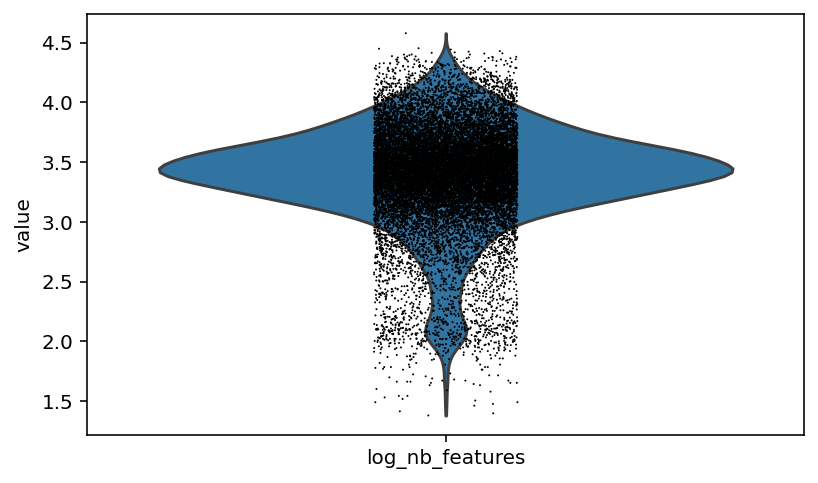

In [12]:
epi.pl.violin(adata, ["log_nb_features"])

In [14]:
min_features = np.quantile(adata.obs["nb_features"], 0.1) # filter out lowest 10% of cells
epi.pp.filter_cells(adata, min_features=min_features) 
adata.raw = adata

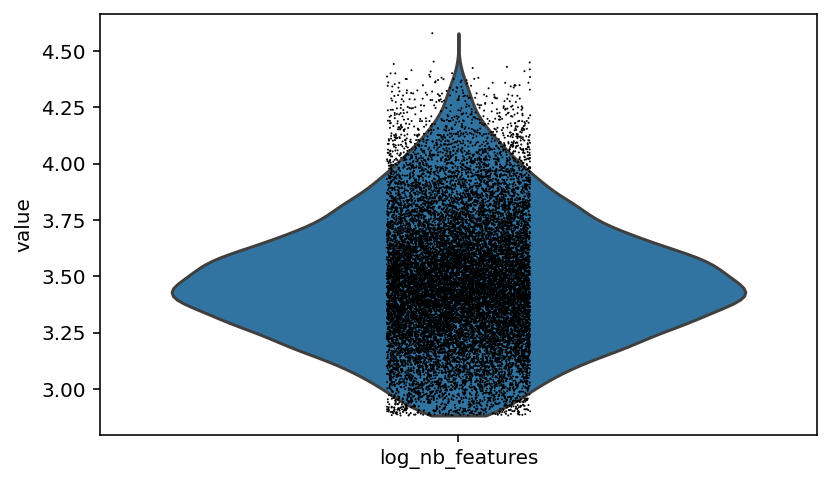

In [15]:
epi.pl.violin(adata, ["log_nb_features"])

In [16]:
adata

AnnData object with n_obs × n_vars = 17157 × 261304
    obs: 'NGI_ID', 'ProcessNumber', 'caseNO', 'Tissue', 'Sex', 'Age', 'PMI', 'MK_ID', '10X_BATCH', 'NGS_BATCH', 'nb_features', 'log_nb_features'
    var: 'n_cells'

In [17]:
sc.tl.pca(adata, zero_center=False, n_comps=50)

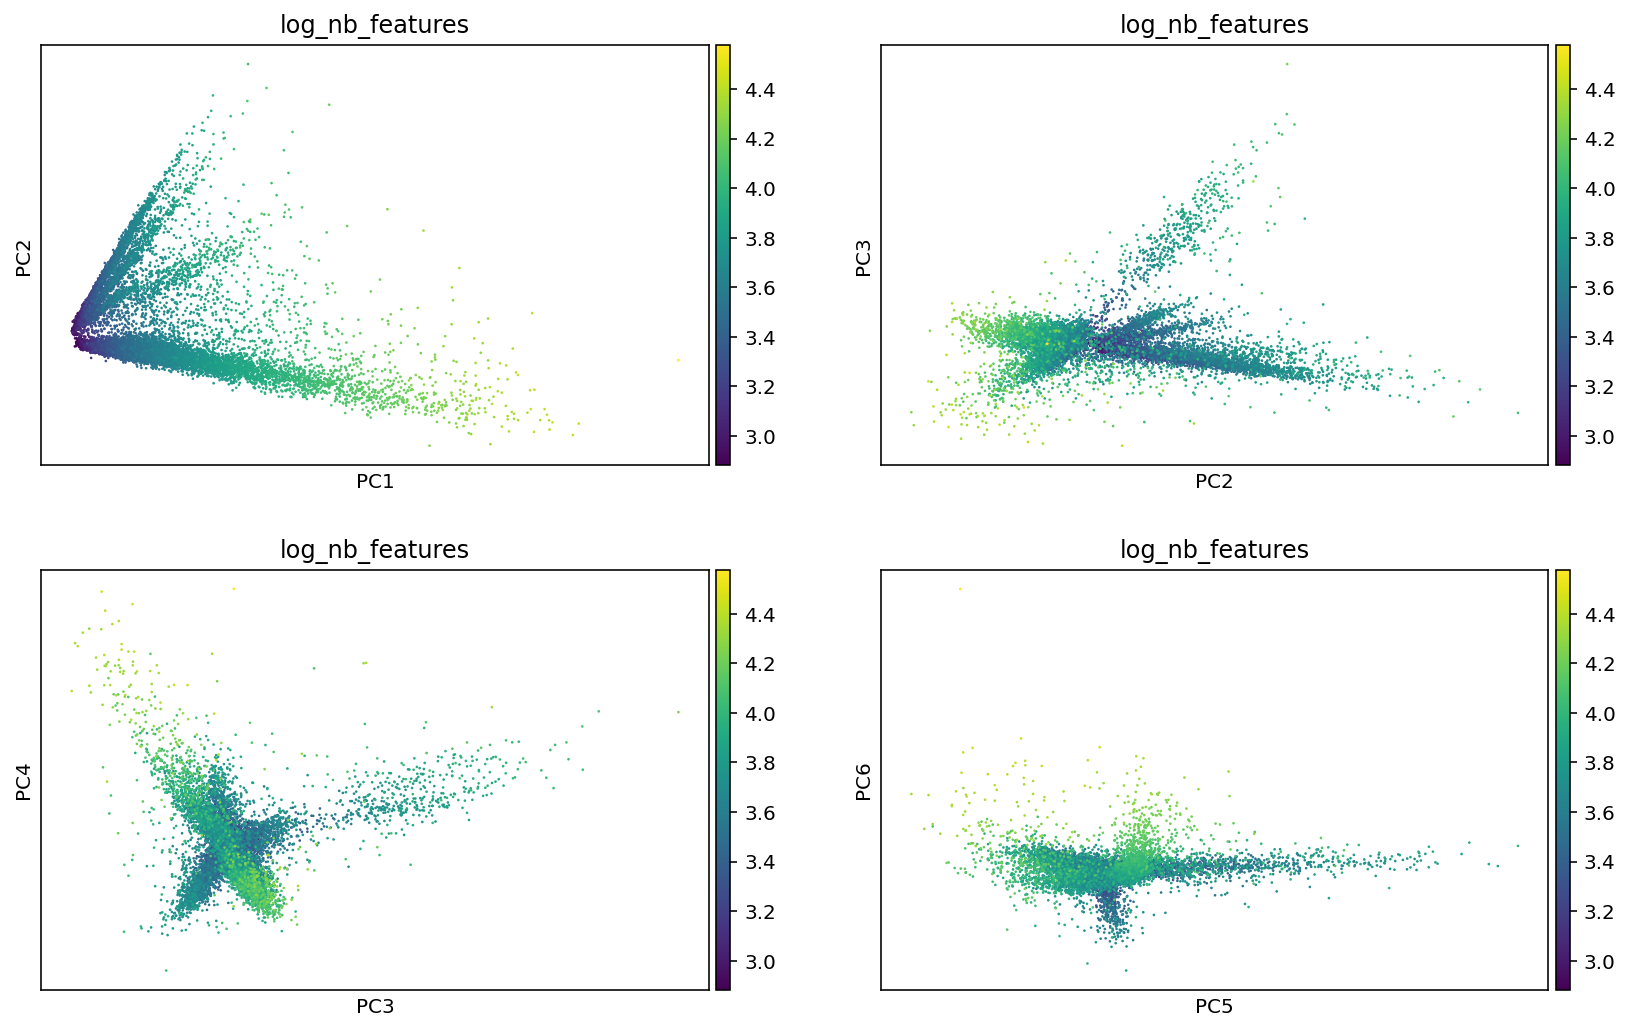

In [18]:
sc.pl.pca(adata, color='log_nb_features', components = ['1,2','2,3','3,4','5,6'], ncols=2)

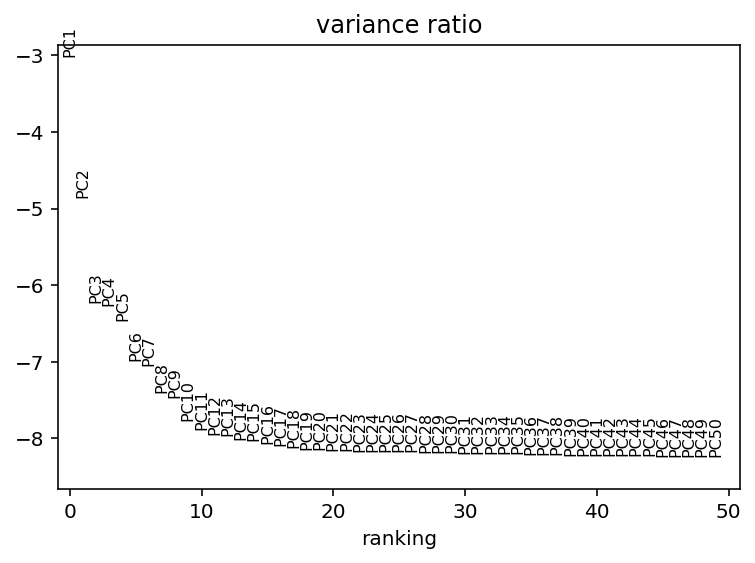

In [19]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [35]:
epi.pp.normalize_total(adata)

In [36]:
sc.pp.neighbors(adata, n_pcs = 50, n_neighbors = 15)

In [37]:
sc.tl.umap(adata, n_components=2)

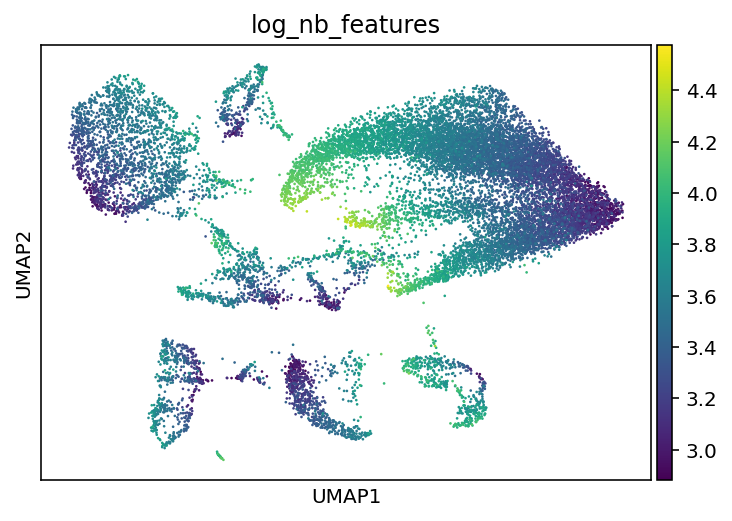

In [38]:
sc.pl.umap(adata, color=["log_nb_features"])

### run TF-IDF to regress out effect of house-keeping features

In [24]:
adata_MK_norm = adata ## make a copy of adata

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer ## used this instead of my custom function

In [26]:
X = adata_MK_norm.X

In [27]:
## do the TF-IDF
tfidf = TfidfTransformer(use_idf=True)
X_norm = tfidf.fit_transform(X)

In [28]:
adata_MK_norm.X = X_norm

In [29]:
sc.tl.pca(adata_MK_norm,  zero_center=False, n_comps=50)

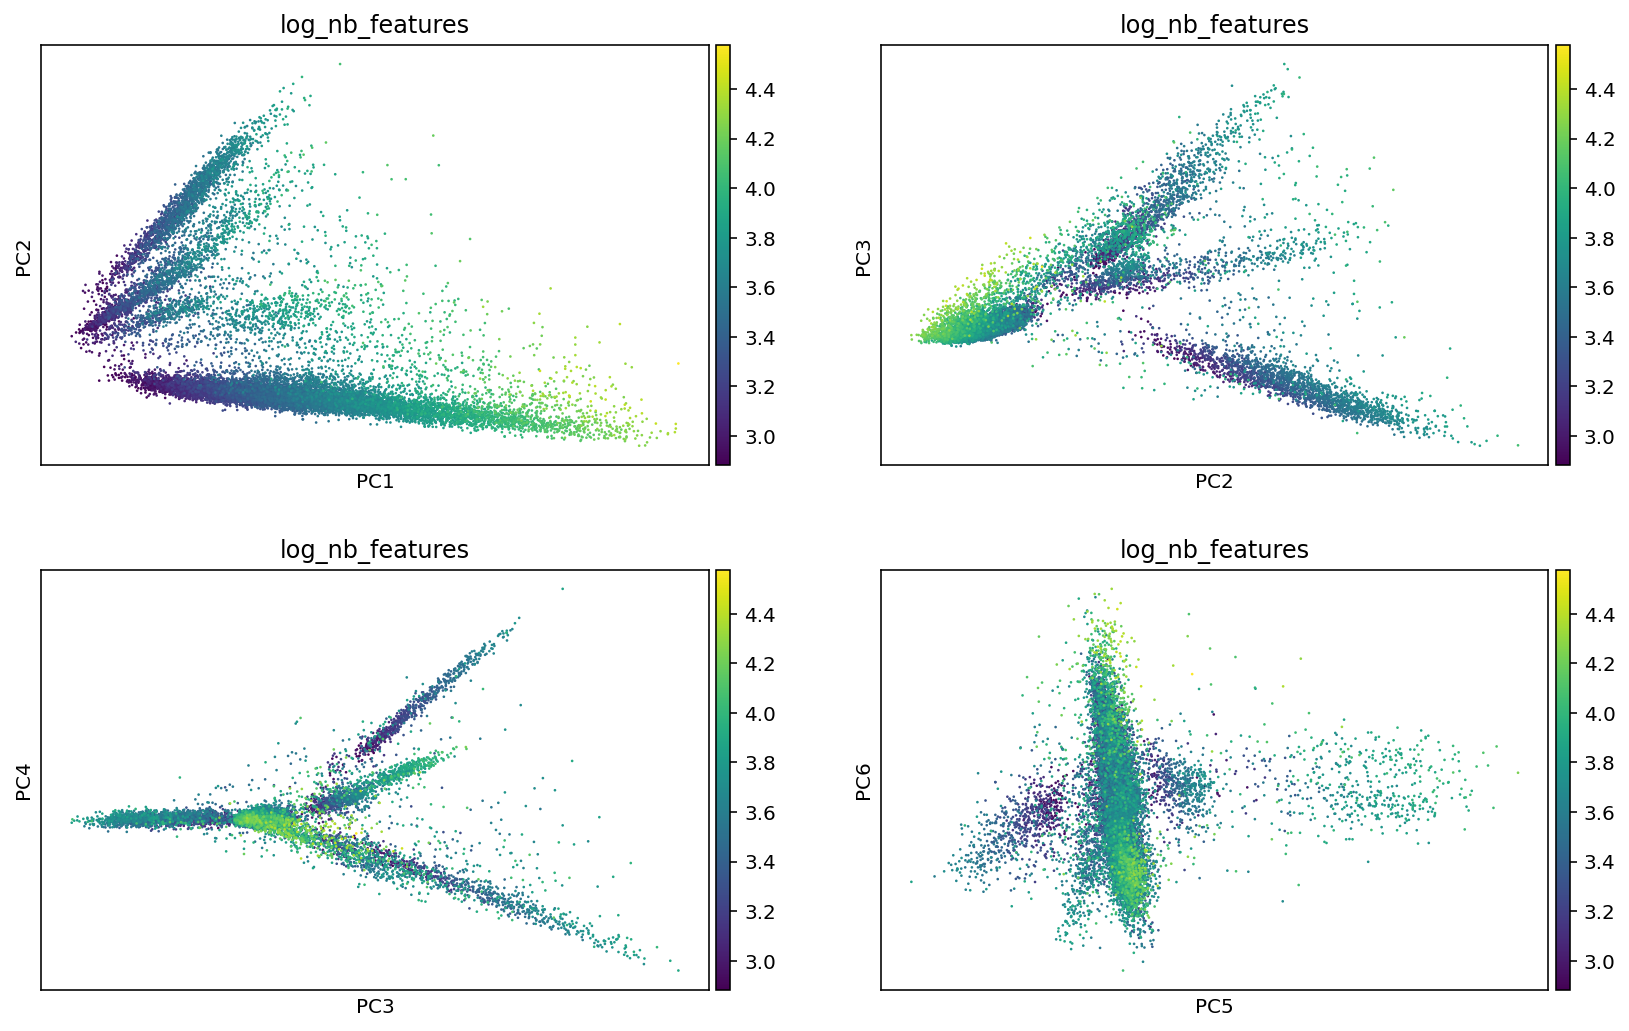

In [30]:
sc.pl.pca(adata_MK_norm, color='log_nb_features', components = ['1,2','2,3','3,4','5,6'], ncols=2)

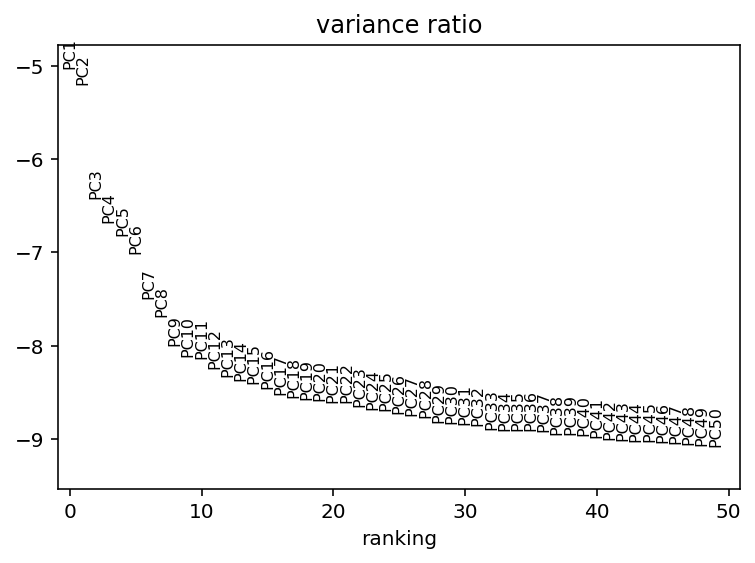

In [31]:
sc.pl.pca_variance_ratio(adata_MK_norm, log=True, n_pcs = 50)

In [39]:
adata_MK_norm

AnnData object with n_obs × n_vars = 17157 × 261304
    obs: 'NGI_ID', 'ProcessNumber', 'caseNO', 'Tissue', 'Sex', 'Age', 'PMI', 'MK_ID', '10X_BATCH', 'NGS_BATCH', 'nb_features', 'log_nb_features'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [32]:
sc.pp.neighbors(adata_MK_norm, n_pcs = 50, n_neighbors = 15)

In [33]:
sc.tl.umap(adata_MK_norm, n_components=2)

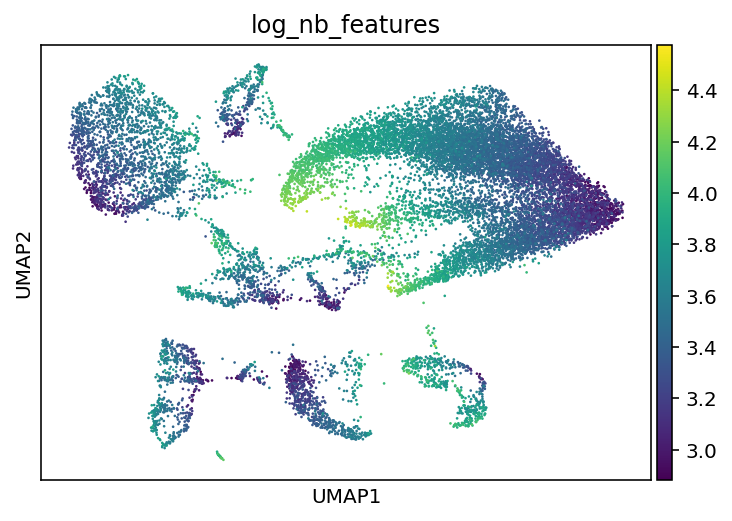

In [34]:
sc.pl.umap(adata_MK_norm, color=["log_nb_features"])

In [40]:
epi.tl.louvain(adata_MK_norm)
epi.tl.kmeans(adata_MK_norm, num_clusters=8)
epi.tl.hc(adata_MK_norm, num_clusters=10)

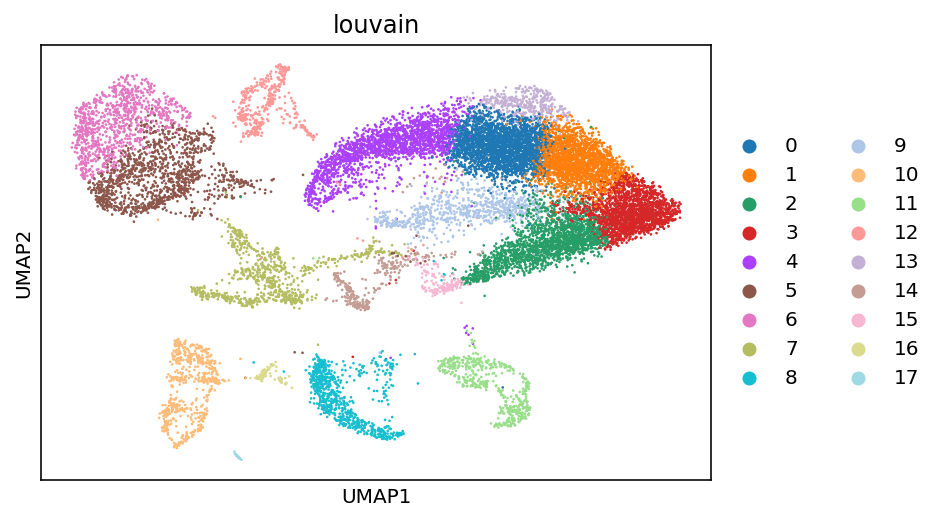

In [44]:
sc.pl.umap(adata_MK_norm, color=["louvain"], wspace=3)# "kmeans", "hc"], wspace=0.3)